Imports

In [93]:
import numpy as np
from numpy.random import multivariate_normal 
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Input
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Q1.a. Generate a bi-variate normal distribution assuming a two dimensional random vector. Accept the values
of parameters required to generate it from the user. Plot the distribution obtained also.

In [94]:
def gnormal_2d(mean1=5,mean2=30,var1=1,var2=20,covariance=-1,size=1000):
	mean = [mean1, mean2]
	covar = [[var1,covariance],[covariance,var2]]
	return multivariate_normal(mean,covar,size)

Q1.b. Create a random sample set (S1) of 800 size from this distribution and plot it.

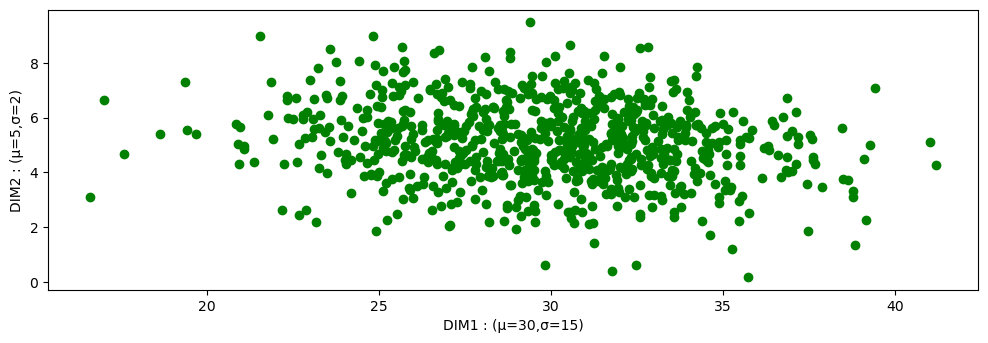

In [95]:

mean1 = 30
var1 = 15
mean2 = 5
var2 = 2
size = 800

df = gen_normal_2d(mean1,mean2,var1,var2,size=size)

x = [int(item[0]) for item in df]
y = [int(item[1]) for item in df]

x = Counter(x)
y = Counter(y)

x = [[value,x[value]] for value in x]
y = [[value,y[value]] for value in y]


# plotting data 
from matplotlib import pyplot as plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_gridspec(2,2)

subplot_0_01 = fig.add_subplot(ax[0,:])
subplot_0_01.scatter([item[0] for item in df],[item[1] for item in df],color='green')
subplot_0_01.set_xlabel("DIM1 : (μ=%d,σ=%d)"%(mean1,var1))
subplot_0_01.set_ylabel("DIM2 : (μ=%d,σ=%d)"%(mean2,var2))

plot.show()

Q1.c. For the sample obtained, what would be size of the required hypothesis class for a maximum error of 0.0,
0.05, 0.1, 0.3, 0.5, 0.8 and 1.0.

In [96]:
def calculate_sample_size(epsilon, delta, VC_dim):
    return 1/epsilon * (4 * np.log2(2/delta) + 8 * VC_dim * np.log2(13/epsilon))

VC_dim = 10
delta = 0.05
max_errors = [0.05, 0.1, 0.3, 0.5, 0.8, 1.0]

for error in max_errors:
    sample_size = calculate_sample_size(error, delta, VC_dim)
    print(f"For maximum error {error}: Sample size required = {sample_size}")

For maximum error 0.05: Sample size required = 13261.542748436515
For maximum error 0.1: Sample size required = 5830.771374218258
For maximum error 0.3: Sample size required = 1520.9337912137778
For maximum error 0.5: Sample size required = 794.6457796616736
For maximum error 0.8: Sample size required = 428.8464217772822
For maximum error 1.0: Sample size required = 317.32288983083686


Q2.a. Divide the sample set into a train set and test set using the 80:20 method.

In [97]:
mean1 = 5
var1 = 1
mean2 = 30
var2 =20
data = gen_normal_2d(mean1=mean1, mean2=mean2, var1=var1, var2=var2, size=800)
train_data, test_data = train_test_split(data,test_size=.2)

Q2.b. Generate a linear regression model using the train set, plot the model obtained and report the error in
prediction for both the train and test set. Give the parametric form of the model also.

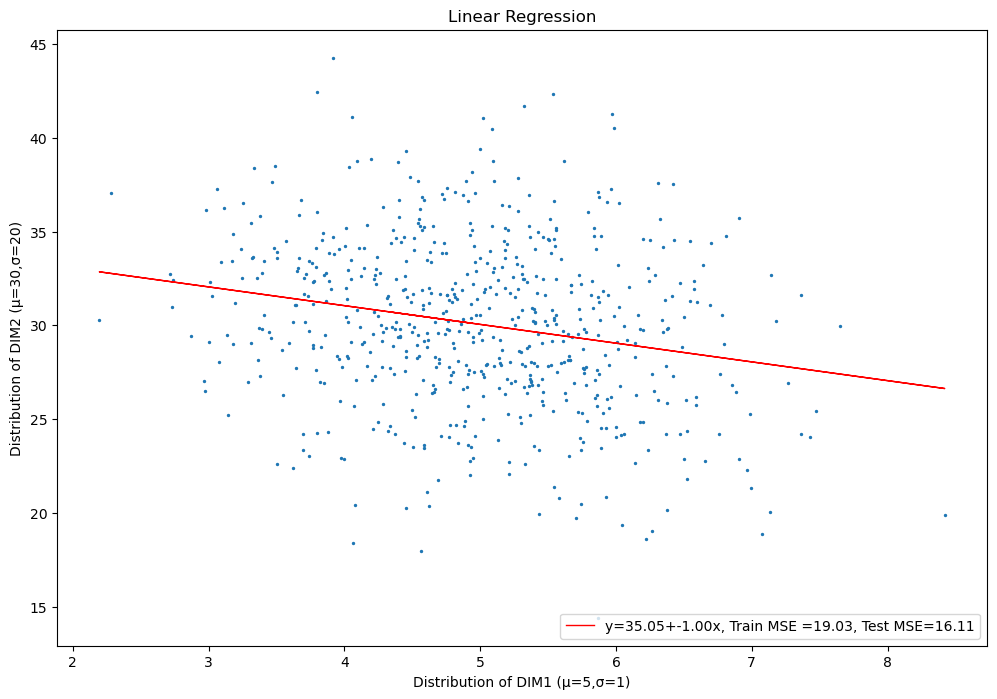

In [98]:



df_train = pd.DataFrame(train_data,columns=['x','y'])

n = len(df_train)
sum_x = sum(df_train['x'])
sum_y = sum(df_train['y'])
sum_xy = sum(df_train['x']*df_train['y'])
sum_x2 = sum(df_train['x']*df_train['x'])
b1 = (n*sum_xy-sum_x*sum_y)/(n*sum_x2-sum_x**2)
b0 = (sum_y-b1*sum_x)/n

df_train['predicted'] = b0+b1*df_train['x']

plt.figure(figsize=(12, 8))
plt.scatter(df_train['x'],df_train['y'],s=2)
plt.title("Linear Regression")
plt.xlabel("Distribution of DIM1 (μ=%d,σ=%d)"%(mean1,var1))
plt.ylabel("Distribution of DIM2 (μ=%d,σ=%d)"%(mean2,var2))
train_error = sum((df_train['y']-df_train['predicted'])**2)/n
df_test = pd.DataFrame(test_data,columns=['x','y'])
df_test['predicted'] = b0+b1*df_test['x']
test_error = sum((df_test['y']-df_test['predicted'])**2)/len(df_test)
plt.plot(
    df_train['x'],df_train['predicted'],color='red',lw=1,
    label='y=%.2f+%.2fx, Train MSE =%.2f, Test MSE=%.2f'%(b0,b1,train_error,test_error)
)
plt.legend(loc="lower right")
plt.show()

Q2.c. Randomly select 700 points from the 800 sample set obtained in Q1.b and assign ”C1” as their class label
and let ”C2” be the class label for the remaining 100 points. Plot C1 and C2 classes. Combine these points into
a new sample set S2 of size 800.

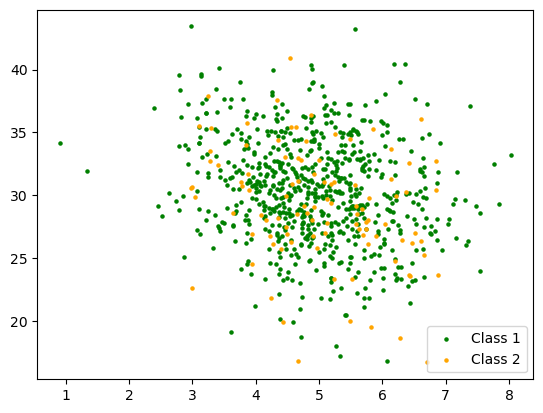

In [99]:
# 2c 
mean1 = 5
var1 = 1
mean2 = 30
var2 =20
data = gen_normal_2d(mean1=mean1, mean2=mean2, var1=var1, var2=var2, size=800)
data = pd.DataFrame(data,columns=['x','y'])
df_c1, df_c2 = train_test_split(data,test_size=(100/800))

df_c1['class'] = 0
df_c2['class'] = 1

plt.scatter(df_c1['x'],df_c1['y'],color='green',s=5,label='Class 1')
plt.scatter(df_c2['x'],df_c2['y'],color='orange',s=5,label='Class 2')
plt.legend(loc='lower right')
plt.show()

df = pd.concat([df_c1, df_c2])
df = df.sample(frac=1).reset_index(drop=True)

Q2.d. Create a train set of size 600 by randomly sampling S2 and let the remaining 200 samples make the test set.

In [100]:
EPOCHS = 20



# ## code to avoid class imbalance

def get_600():
    x_train, x_test, y_train, y_test = train_test_split(df[['x','y']],df[['class']],test_size=(200/800),stratify=df[['class']])
    
    train_df = pd.concat([x_train,y_train],axis=1)
    test_df = pd.concat([x_test,y_test],axis=1)
    
    x_train = np.array(x_train)
    y_train = to_categorical(y_train)
    
    x_test = np.array(x_test)
    y_test = to_categorical(y_test)

    return x_train, x_test, y_train, y_test, train_df, test_df

x_train, x_test, y_train, y_test, train_df, test_df = get_600()

Make a multi-layer perceptron model to classify the C1 and C2 points.

In [101]:
def get_ann():
    ann = Sequential()
    ann.add(Input((2,)))
    ann.add(BatchNormalization())
    ann.add(Dense(units=4,activation='relu'))
    ann.add(BatchNormalization())
    ann.add(Dense(units=2,activation='softmax'))
    return ann

ann = get_ann()
ann.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy', 'precision','recall','f1_score'])
ann.fit(x_train,y_train,epochs=EPOCHS,verbose=0)

ann.evaluate(x_train,y_train)
ann.evaluate(x_test,y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8476 - f1_score: 0.5000 - loss: 0.4772 - precision: 0.8476 - recall: 0.8476
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8479 - f1_score: 0.5155 - loss: 0.4741 - precision: 0.8479 - recall: 0.8479 


[0.4726843237876892,
 0.8550000190734863,
 0.8550000190734863,
 0.8550000190734863,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9209808, 0.1212121], dtype=float32)>]

Report the confusion matrix, accuracy, precision, recall and F1-score, Give the parametric form of the model obtained also.

In [102]:
y_pred = ann.predict(x_test)
test_df['predict'] = [0 if item[0]>item[1] else 1 for item in y_pred]
c_matrix = pd.DataFrame(
    [
        [
            len(test_df[(test_df['class']==test_df['predict']) & (test_df['predict']==0)]),
            len(test_df[(test_df['class']!=test_df['predict']) & (test_df['class']==1) & (test_df['predict']==0)]),
        ],
        [
            len(test_df[(test_df['class']!=test_df['predict']) & (test_df['class']==0) & (test_df['predict']==1)]),
            len(test_df[(test_df['class']==test_df['predict']) & (test_df['predict']==1)]),
        ]
    ],
    columns=['Actual0','Actual1'],
    index=['Predict0','Predict1'])

tp = c_matrix.loc['Predict0','Actual0']
tn = c_matrix.loc['Predict1','Actual1']
fp = c_matrix.loc['Predict0','Actual1']
fn = c_matrix.loc['Predict1','Actual0']
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

print ('PARAMETRIC FORM')
ann.summary()
print ('METRICES')
print ('CONFUSION MATRIX')
print (tabulate(c_matrix,headers='keys',tablefmt='psql'))
print ("Accuracy=%.2f, Precision=%.2f, Recall=%.2f, F1 Score=%.2f"%(accuracy,precision,recall,f1_score))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
PARAMETRIC FORM


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_228              │ (None, 2)                   │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_228 (Dense)                    │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_229              │ (None, 4)                   │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48 (196.00 B)

 Trainable params: 34 (136.00 B)

 Non-trainable params: 12 (48.00 B)

 Optimizer params: 2 (12.00 B)

METRICES
CONFUSION MATRIX
+----------+-----------+-----------+
|          |   Actual0 |   Actual1 |
|----------+-----------+-----------|
| Predict0 |       169 |        23 |
| Predict1 |         6 |         2 |
+----------+-----------+-----------+
Accuracy=0.85, Precision=0.88, Recall=0.97, F1 Score=0.92


Plot the ROC curve and report the AUC value also.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


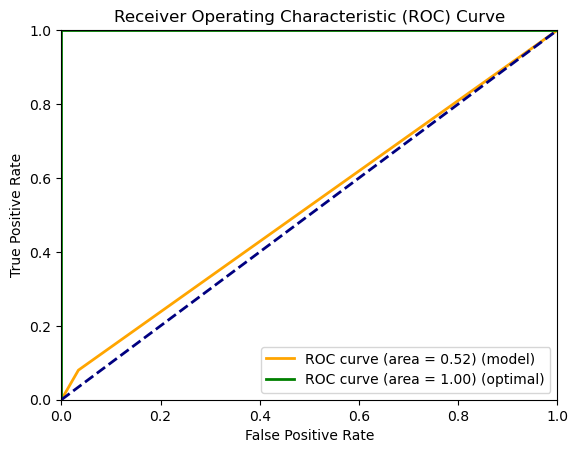

In [103]:
y_true = test_df['class']
y_pred = ann.predict(x_test)
y_pred = [0 if item[0]>item[1] else 1 for item in y_pred]

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

o_fpr, o_tpr, _ = roc_curve(y_true, y_true)
o_roc_auc = auc(o_fpr,o_tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f) (model)' % roc_auc)
plt.plot(o_fpr, o_tpr, color='green', lw=2, label='ROC curve (area = %0.2f) (optimal)' % o_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Q2.e. Carry out a k-fold stratied cross validation and report the various performance metric values for the same number of train and test set samples. Compare these values with that obtained in Q2.d.

In [104]:
# 2e

k_folds = 5

accuracy_scores = []
precision_scores = []

kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

x_train = train_df[['x','y']]
y_train = train_df['class']

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x_train,y_train):
    
    x_train_fold = np.array(x_train.iloc[train_index])
    x_test_fold = np.array(x_train.iloc[test_index])

    y_train_fold = to_categorical(y_train.iloc[train_index])
    y_test_fold = to_categorical(y_train.iloc[test_index])

    ann = get_ann()
    ann.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', 'precision','recall','f1_score'])

    ann.fit(x_train_fold, y_train_fold, epochs=EPOCHS, verbose=0)
    ann.evaluate(x_test_fold, y_test_fold)

    print (len(ann.get_weights()))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8833 - f1_score: 0.4690 - loss: 0.4814 - precision: 0.8833 - recall: 0.8833 
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8896 - f1_score: 0.4707 - loss: 0.4281 - precision: 0.8896 - recall: 0.8896 
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8400 - f1_score: 0.4565 - loss: 0.5490 - precision: 0.8400 - recall: 0.8400  
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9023 - f1_score: 0.5430 - loss: 0.3710 - precision: 0.9023 - recall: 0.9023
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8354 - f1_score: 0.6182 - loss: 0.4712 - precision: 0.8354 - recall: 0.8354 
12


Q3.a. For the above model, plot the loss function against any one of the weights from input-to-hidden edges
and any one of the weights from hidden-to-output edges. Apply 5 dierent learning rates and compare the loss
plots obtained

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8490 - f1_score: 0.4591 - loss: 0.4204 - precision: 0.8490 - recall: 0.8490


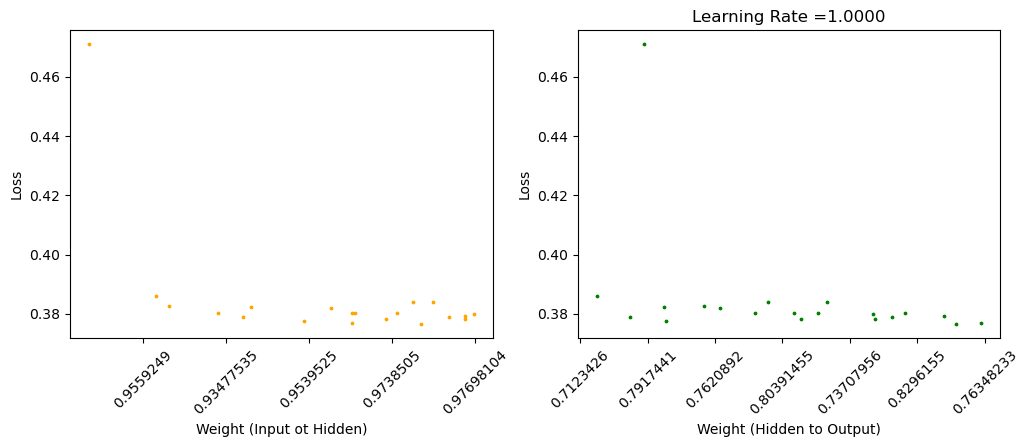

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8490 - f1_score: 0.4591 - loss: 0.4189 - precision: 0.8490 - recall: 0.8490


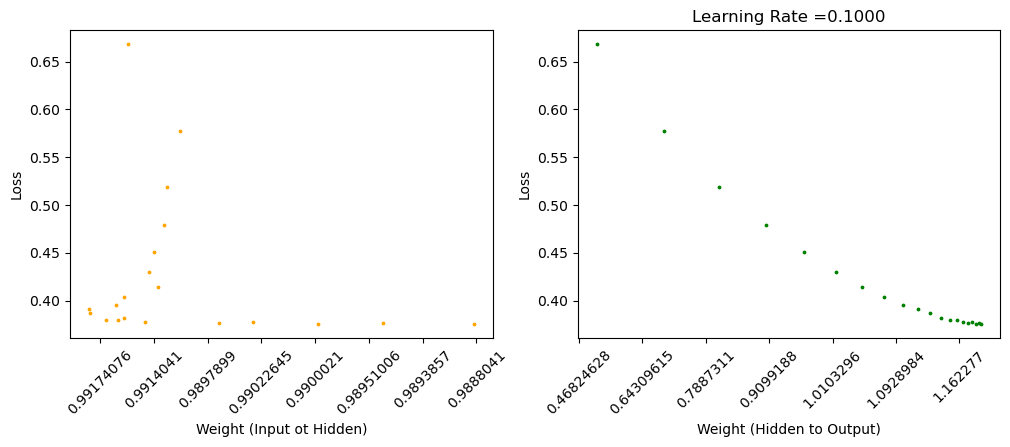

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8575 - f1_score: 0.5162 - loss: 0.5267 - precision: 0.8575 - recall: 0.8575


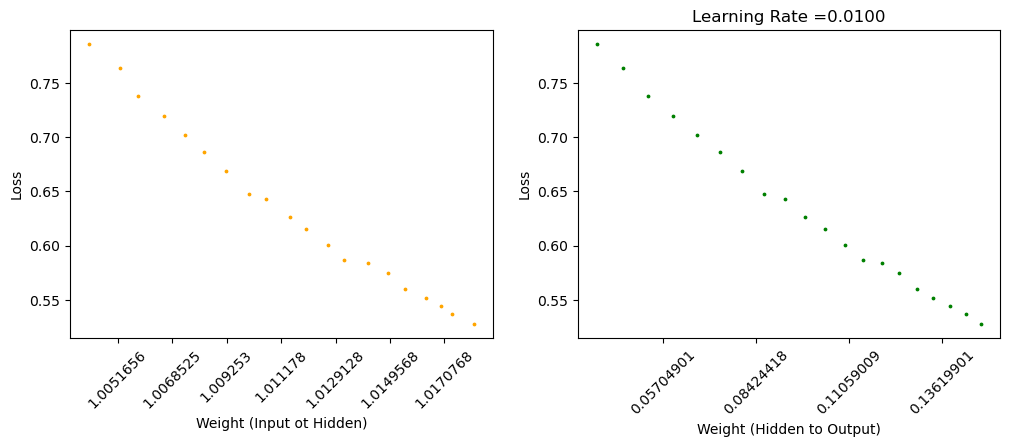

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4708 - f1_score: 0.4238 - loss: 0.8231 - precision: 0.4708 - recall: 0.4708


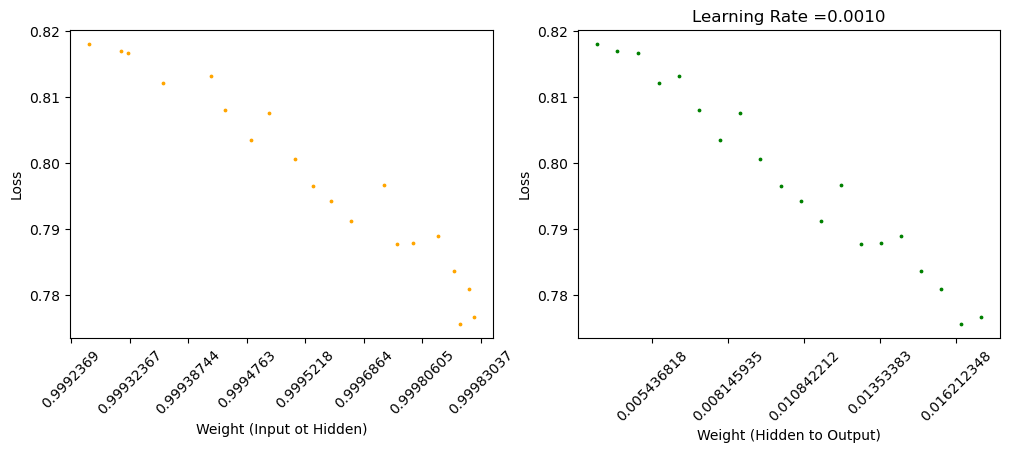

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5671 - f1_score: 0.3733 - loss: 0.7356 - precision: 0.5671 - recall: 0.5671


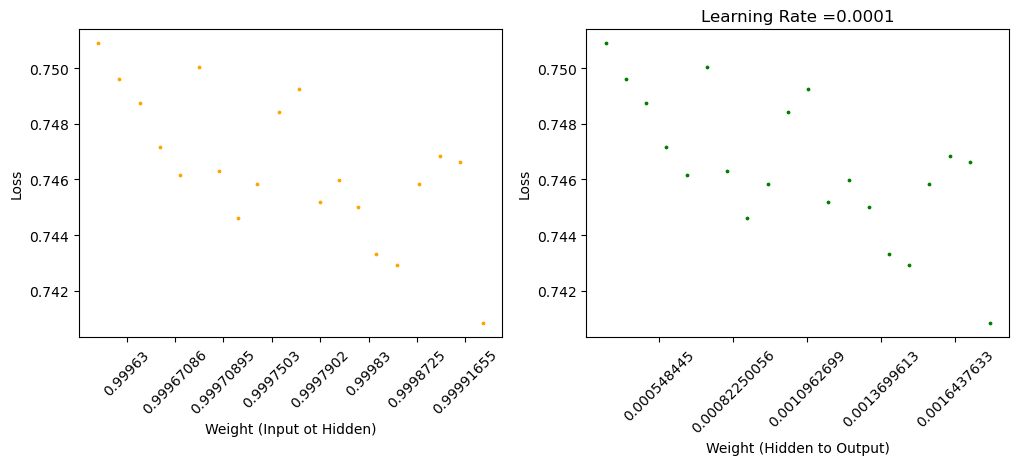

In [108]:
# 3a
learning_rates = [1.0, 0.1, 0.01, 0.001, 0.0001]

for rate in learning_rates:
    
    ann = get_ann()
    
    checkpoint_callback = ModelCheckpoint('./weights/_r_%.4f_e_{epoch:02d}.weights.h5'%(rate), save_weights_only=True)
    ann.compile(
        optimizer=SGD(learning_rate=rate), 
        loss='binary_crossentropy', 
        metrics=['accuracy', 'precision','recall','f1_score']
    )
    
    history = ann.fit(x_train_fold, y_train_fold, epochs=EPOCHS, verbose=0, callbacks=[checkpoint_callback])
    ann.evaluate(x_test_fold, y_test_fold)
    loss_per_epoch = history.history['loss']
    plot_data = {
        'y' : loss_per_epoch,
        'input_to_hidden' : [],
        'hidden_to_output' : []
    }
    for e in range(1,len(loss_per_epoch)+1) :
        filename = './weights/_r_%.4f_e_%02d.weights.h5'%(rate,e)
        ann.load_weights(filename)
        temp = ann.get_weights()
        plot_data['input_to_hidden'].append(temp[0][0])
        plot_data['hidden_to_output'].append(temp[-1][0])
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_gridspec(1,2)

    subplot_0_0 = fig.add_subplot(ax[0,0])
    subplot_0_0.scatter(plot_data['input_to_hidden'],plot_data['y'],color='orange',s=3)
    subplot_0_0.set_xlabel("Weight (Input ot Hidden)")
    subplot_0_0.set_ylabel("Loss")
    if plot_data['input_to_hidden'][0]>plot_data['input_to_hidden'][-1] :
        subplot_0_0.invert_xaxis()   
    subplot_0_0.set_xticklabels(plot_data['input_to_hidden'],rotation=45)

    subplot_0_1 = fig.add_subplot(ax[0,1])
    subplot_0_1.scatter(plot_data['hidden_to_output'],plot_data['y'],color='green',s=3)
    subplot_0_1.set_xlabel("Weight (Hidden to Output)")
    subplot_0_1.set_ylabel("Loss")
    if plot_data['hidden_to_output'][0]>plot_data['hidden_to_output'][-1] :
        subplot_0_1.invert_xaxis()
        
    subplot_0_1.set_xticklabels(plot_data['hidden_to_output'],rotation=45)
   
    plt.title('Learning Rate =%.4f'%(rate))

    plt.show()


Q3.b. Repeat Q2.d. for two more different random initialization of weights and compare the results obtained
with that obtained in Q2.d.

WEIGHTS
batch_normalization_260
[1. 1.]
dense_260
[[ 0.5368087   0.88241625  0.85418415  0.37096643]
 [ 0.22765446 -0.0206027  -0.89379716 -0.3970492 ]]
batch_normalization_261
[1. 1. 1. 1.]
dense_261
[[ 0.73811007  0.7267914 ]
 [ 0.5016155   0.6243572 ]
 [ 0.7869251  -0.8751259 ]
 [ 0.00098634  0.06957245]]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8731 - f1_score: 0.4661 - loss: 0.4574 - precision: 0.8731 - recall: 0.8731
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8805 - f1_score: 0.4682 - loss: 0.4394 - precision: 0.8805 - recall: 0.8805 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
METRICES
CONFUSION MATRIX
+----------+-----------+-----------+
|          |   Actual0 |   Actual1 |
|----------+-----------+-----------|
| Predict0 |       175 |        25 |
| Predict1 |         0 |         0 |
+----------+-----------+-----------+
Accuracy=0.88, Precision=0.88, Recall=1.00, F1 Score=0.93
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


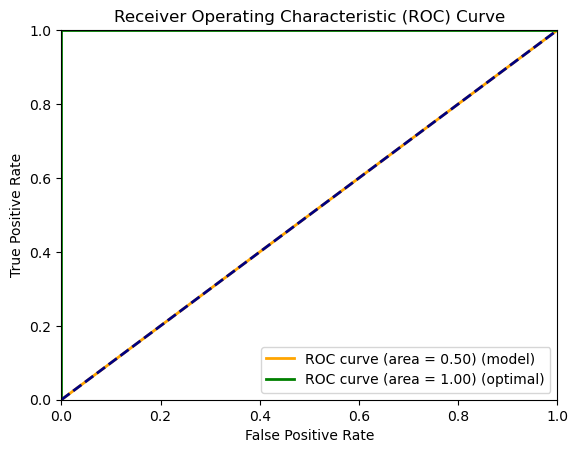


WEIGHTS
batch_normalization_262
[1. 1.]
dense_262
[[-0.79025245  0.21387696  0.7135885  -0.12800741]
 [ 0.7969618   0.60824704  0.01118445  0.05800891]]
batch_normalization_263
[1. 1. 1. 1.]
dense_263
[[-0.44205785 -0.743644  ]
 [-0.6792247  -0.49458647]
 [ 0.5478883  -0.7396097 ]
 [-0.01909518  0.8617983 ]]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8731 - f1_score: 0.4661 - loss: 0.4739 - precision: 0.8731 - recall: 0.8731
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8805 - f1_score: 0.4682 - loss: 0.4645 - precision: 0.8805 - recall: 0.8805 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
METRICES
CONFUSION MATRIX
+----------+-----------+-----------+
|          |   Actual0 |   Actual1 |
|----------+-----------+-----------|
| Predict0 |       175 |        25 |
| Predict1 |         0 |         0 |
+----------+-----------+-----------+
Accuracy=0.88, Precision=0.88, Recall=1.00, F1 Score=0.93
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


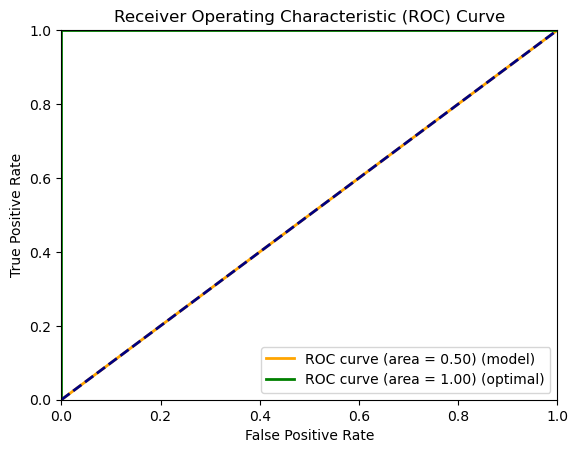


WEIGHTS
batch_normalization_264
[1. 1.]
dense_264
[[ 0.73573613  0.94748664 -0.06187582 -0.4095788 ]
 [ 0.383075   -0.80158424  0.9618468   0.52047443]]
batch_normalization_265
[1. 1. 1. 1.]
dense_265
[[ 0.67587805  0.6609769 ]
 [-0.9471574  -0.5317173 ]
 [ 0.14106393 -0.18369484]
 [ 0.6092727   0.17072296]]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8682 - f1_score: 0.4777 - loss: 0.5115 - precision: 0.8682 - recall: 0.8682
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8664 - f1_score: 0.4900 - loss: 0.5453 - precision: 0.8664 - recall: 0.8664 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
METRICES
CONFUSION MATRIX
+----------+-----------+-----------+
|          |   Actual0 |   Actual1 |
|----------+-----------+-----------|
| Predict0 |       173 |        24 |
| Predict1 |         2 |         1 |
+----------+-----------+-----------+
Accuracy=0.87, Precision=0.88, Recall=0.99, F1 Score=0.93
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


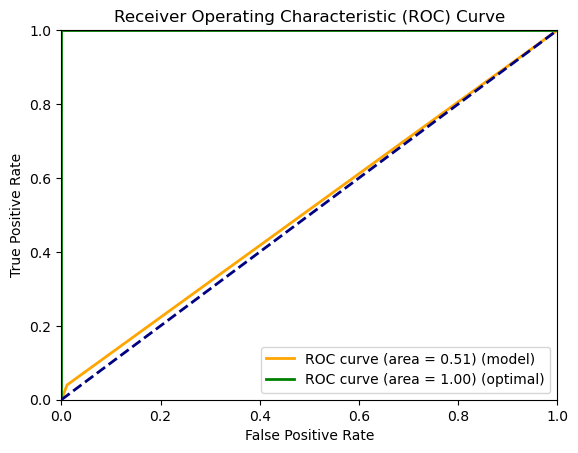


WEIGHTS
batch_normalization_266
[1. 1.]
dense_266
[[ 0.9391329  -0.7443135  -0.08479476 -0.02594066]
 [ 0.33026838 -0.7220671  -0.48129916  0.4944892 ]]
batch_normalization_267
[1. 1. 1. 1.]
dense_267
[[-0.06947541 -0.6644783 ]
 [-0.32297277  0.9552684 ]
 [ 0.43668532  0.7924051 ]
 [ 0.93901324 -0.61417294]]

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8613 - f1_score: 0.4949 - loss: 0.4274 - precision: 0.8613 - recall: 0.8613
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8620 - f1_score: 0.4758 - loss: 0.4758 - precision: 0.8620 - recall: 0.8620 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
METRICES
CONFUSION MATRIX
+----------+-----------+-----------+
|          |   Actual0 |   Actual1 |
|----------+-----------+-----------|
| Predict0 |       172 |        24 |
| Predict1 |         3 |         1 |
+----------+-----------+-----------+
Accuracy=0.86, Precision=0.88, Recall=0.98, F1 Score=0.93
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


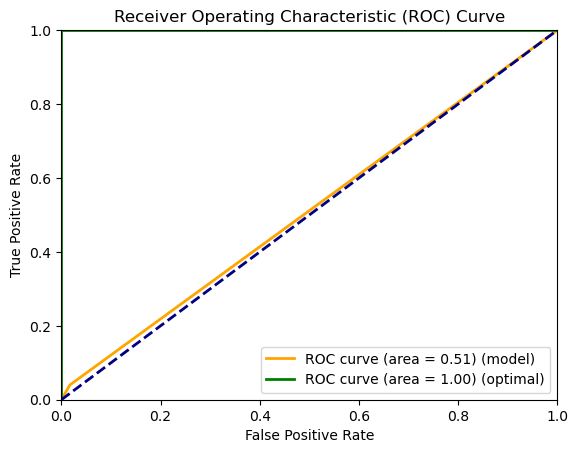


WEIGHTS
batch_normalization_268
[1. 1.]
dense_268
[[-0.00869131 -0.4048953   0.18740368  0.45289373]
 [ 0.7661903   0.01361442  0.41761398  0.8084948 ]]
batch_normalization_269
[1. 1. 1. 1.]
dense_269
[[-0.77097464  0.6287763 ]
 [ 0.1757989  -0.4107077 ]
 [-0.4423921   0.9604397 ]
 [-0.7426276  -0.06592202]]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8528 - f1_score: 0.4728 - loss: 0.4608 - precision: 0.8528 - recall: 0.8528 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8559 - f1_score: 0.4612 - loss: 0.4441 - precision: 0.8559 - recall: 0.8559 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
METRICES
CONFUSION MATRIX
+----------+-----------+-----------+
|          |   Actual0 |   Actual1 |
|----------+-----------+-----------|
| Predict0 |       170 |        25 |
| Predict1 |         5 |         0 |
+----------+-----------+-----------+
Accuracy=0.85, Precision=0.87, Recall=0.97, F1 Score=0.92
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


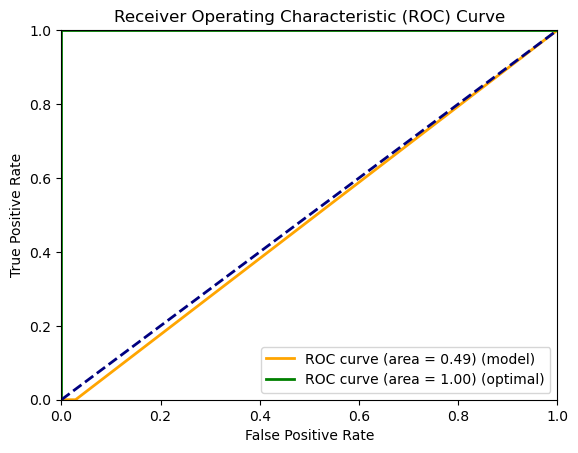

In [107]:
x_train, x_test, y_train, y_test, train_df, test_df = get_600()

for _ in range (5):
    
    ann = get_ann()
    ann.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy', 'precision','recall','f1_score'])
    
    print ('WEIGHTS')
    for layer in ann.layers:
        print (layer.name)
        print (np.array(layer.weights[0]))
    print ()
    
    ann.fit(x_train,y_train,epochs=EPOCHS,verbose=0)
    ann.evaluate(x_train,y_train)
    ann.evaluate(x_test,y_test)

    y_pred = ann.predict(x_test)
    test_df['predict'] = [0 if item[0]>item[1] else 1 for item in y_pred]
    c_matrix = pd.DataFrame(
        [
            [
                len(test_df[(test_df['class']==test_df['predict']) & (test_df['predict']==0)]),
                len(test_df[(test_df['class']!=test_df['predict']) & (test_df['class']==1) & (test_df['predict']==0)]),
            ],
            [
                len(test_df[(test_df['class']!=test_df['predict']) & (test_df['class']==0) & (test_df['predict']==1)]),
                len(test_df[(test_df['class']==test_df['predict']) & (test_df['predict']==1)]),
            ]
        ],
        columns=['Actual0','Actual1'],
        index=['Predict0','Predict1'])

    tp = c_matrix.loc['Predict0','Actual0']
    tn = c_matrix.loc['Predict1','Actual1']
    fp = c_matrix.loc['Predict0','Actual1']
    fn = c_matrix.loc['Predict1','Actual0']
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = (tp/(tp+fp))
    recall = (tp/(tp+fn))
    f1_score = 2*((precision*recall)/(precision+recall))

    print ('METRICES')
    print ('CONFUSION MATRIX')
    print (tabulate(c_matrix,headers='keys',tablefmt='psql'))
    print ("Accuracy=%.2f, Precision=%.2f, Recall=%.2f, F1 Score=%.2f"%(accuracy,precision,recall,f1_score))
    
    y_true = test_df['class']
    y_pred = ann.predict(x_test)
    y_pred = [0 if item[0]>item[1] else 1 for item in y_pred]

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    o_fpr, o_tpr, _ = roc_curve(y_true, y_true)
    o_roc_auc = auc(o_fpr,o_tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f) (model)' % roc_auc)
    plt.plot(o_fpr, o_tpr, color='green', lw=2, label='ROC curve (area = %0.2f) (optimal)' % o_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print()